<a href="https://colab.research.google.com/github/SPThole/BMS-Molecular-Translation/blob/main/NER_BERT/BERT_ner_pytorch_lightning_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing/ Importing required libraries

In [10]:
# !pip install torch==1.4
!pip install transformers
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch_lightning
# !pip install --quiet "pytorch-lightning>=1.3"


  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm_notebook as tqdm
import pytorch_lightning as pl

import transformers
from transformers import BertForTokenClassification, AdamW
%matplotlib inline

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
device

'cpu'

In [14]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

In [15]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/entity-annotated-corpus.zip', 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive")

In [16]:
# !pip install transformers

In [17]:
df = pd.read_csv('/content/drive/MyDrive/ner.csv', encoding = "ISO-8859-1", error_bad_lines=False)
df1 = pd.read_csv('/content/drive/MyDrive/ner_dataset.csv', encoding = "ISO-8859-1", error_bad_lines=False)

In [18]:
df1['Sentence #'] = df1['Sentence #'].fillna(method = 'ffill')
Label_encoder = LabelEncoder()
df1["Tag"] = Label_encoder.fit_transform(df1["Tag"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


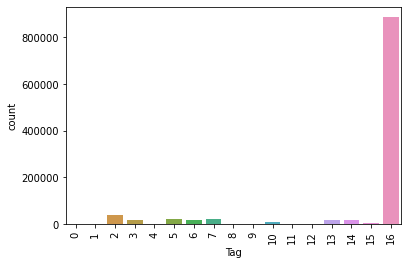

In [19]:
sns.countplot(df1['Tag'])
plt.xticks(rotation=90)
plt.show()

In [20]:
sentences = list(df1.groupby("Sentence #")["Word"].apply(list).reset_index()['Word'].values)
vals = list(df1.groupby("Sentence #")["Tag"].apply(list).reset_index()['Tag'].values)
sentences = [" ".join(s) for s in sentences]

In [21]:
# from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence
tokenizer = transformers.BertTokenizer.from_pretrained(
        'bert-base-cased',
        do_lower_case=True
    )

In [22]:
class ner_dataset(Dataset):

  def __init__(self,sentences,vals,tokenizer,max_len):
    self.sentences = sentences
    self.vals = vals
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __getitem__(self,idx):

    s = self.sentences[idx].split(" ")
    v = self.vals[idx]
    d = {'input_ids':[],'attention_mask':[],'labels':[]}
    text = []
    labels = []
    mask = []
    for w in range(len(s)) :
      i, l = self.align_labels(self.tokenizer,s[w],v[w])
      text.extend(i['input_ids'])
      labels.extend(l)
      mask.extend(i['attention_mask'])
    d['input_ids'] = [101] + self.pad(text+ [102],self.max_len)
    d['labels'] = [0] + self.pad(labels+ [0],self.max_len)
    d['attention_mask'] = [1] + self.pad(mask+ [1],self.max_len)

    d['input_ids'] = torch.tensor(d['input_ids'])
    d['labels'] = torch.tensor(d['labels'])
    d['attention_mask'] = torch.tensor(d['attention_mask'])

    return d

  def __len__(self):
    return len(self.sentences)

  def align_labels(self,tokenizer,word,label):
    word = tokenizer(word,add_special_tokens=False)
    labels = []
    for i in range(len(word['input_ids'])):
      labels.append(label)
    return word,labels

  def pad(self,s,max_len):
    pad_len = max_len - len(s)
    if pad_len>0:
      for i in range(pad_len):
        s.append(0)
    return s[:max_len-1]

In [23]:
dataset = ner_dataset(sentences,vals,tokenizer,100)

In [24]:
train_dataset, test_dataset = random_split(dataset,[int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8)])

In [25]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=False)
test_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=False)

In [26]:
class ner_model(nn.Module):
  def __init__(self,num_class):
    super(ner_model,self).__init__()
    self.num_class = num_class
    self.bert = transformers.BertModel.from_pretrained(
            "bert-base-uncased"
        )
    self.logit = nn.Linear(768,self.num_class)
    
  def forward(self,ids,mask):
     x = self.bert(ids, 
            attention_mask=mask)
     x = self.logit(x['last_hidden_state'])
     return x

In [27]:
model = ner_model(df1['Tag'].nunique())
num_class = df1['Tag'].nunique()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.0,
    },
]

optimizer = optim.AdamW(optimizer_parameters,lr=1e-5)


loss_fn = nn.CrossEntropyLoss()

In [29]:
def loss_fn1(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


In [30]:
class NERmodel(pl.LightningModule):
  def __init__(self,model):
    super().__init__()
    self.model = model
   

  def forward(self, x, msk):
    return self.model(x,msk)

  def configure_optimizers(self):
    param_optimizer = list(self.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(
                    nd in n for nd in no_decay
                )
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(
                    nd in n for nd in no_decay
                )
            ],
            "weight_decay": 0.0,
        },
    ]

    optimizer = optim.AdamW(optimizer_parameters,lr=1e-5)
    # optimizer = optim.AdamW(self.para,lr=1e-5)
    return optimizer

  def loss_fn1(self,output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss

  def training_step(self, train_batch, batch_idx):
    d = train_batch
    x, msk = d['input_ids'],d['attention_mask']
    out = self.model(x,msk)
    loss = self.loss_fn1(out, d['labels'], msk, num_class)
    self.log('train_loss', loss)
    # print(loss)
    return loss

  def validation_step(self, val_batch, batch_idx):
    d = val_batch
    x, msk = d['input_ids'],d['attention_mask']
    out = self.model(x,msk)
    loss = self.loss_fn1(out, d['labels'], msk, num_class)
    self.log('val_loss', loss)
    return loss


In [31]:
md =NERmodel(model)
# training
trainer = pl.Trainer(tpu_cores=1,max_epochs=1,precision=16,progress_bar_refresh_rate=1)
trainer.fit(md,train_dataloader, test_dataloader)

GPU available: False, used: False
TPU available: True, using: 1 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type      | Params
------------------------------------
0 | model | ner_model | 109 M 
------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
218.991   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/plugins/training_type/tpu_spawn.py:192: UserWarning: cleaning up tpu spawn environment...
  rank_zero_warn("cleaning up tpu spawn environment...")


In [32]:
model = trainer.model

# Inference 

In [33]:
model = model.to('cpu')
model.eval()

LightningDistributedModule(
  (module): NERmodel(
    (model): ner_model(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
                  (d

In [36]:
text = 'Mr. Steve Jobs founded Apple at Palo Alto around United States'
lent = len(text.split(" "))
infer_dataset = ner_dataset([text],[[1]*lent],tokenizer,100)
ids, msk, ys= infer_dataset[0]['input_ids'], infer_dataset[0]['attention_mask'], infer_dataset[0]['labels']
out = model(ids.unsqueeze(0).to('cpu'),msk.unsqueeze(0).to('cpu'))[0]
out_idx = [torch.argmax(o,dim=-1).item() for o in out]
[Label_encoder.classes_[i] for i in out_idx]

['B-art',
 'B-per',
 'B-per',
 'B-per',
 'I-per',
 'I-per',
 'I-per',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'B-geo',
 'B-geo',
 'B-geo',
 'B-geo',
 'I-geo',
 'B-art',
 'O',
 'O',
 'I-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-per',
 'B-per',
 'O',
 'O',
 'I-per',
 'I-per',
 'I-per',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'B-geo',
 'B-geo',
 'B-geo',
 'B-geo',
 'B-geo',
 'I-geo',
 'I-geo',
 'O',
 'I-per',
 'O',
 'B-geo',
 'O',
 'O',
 'B-geo',
 'B-geo',
 'O',
 'B-per',
 'B-per',
 'B-per',
 'B-per',
 'I-per',
 'I-per',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'B-geo',
 'O',
 'B-geo',
 'O',
 'O',
 'I-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-per',
 'O',
 'O',
 'I-per',
 'I-per',
 'I-per',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'I-geo',
 'I-geo']